# Fully Convolutional Networks and Pneumonia Classification
For this project, I will be performing a binary classification on x-ray image data. Mainly this exercise will run through how to quickly set up an image classification pipeline
using high level Keras tools. This problem helps showcase helpful techniques to deal with large image datasets with different dimensions, as well as how to turn our raw data into trainable batches. I will also run through helpful ways to evaluate medical data and give some intuition on architecture design.

## Dataset: Chest X-rays
Our data comes courtesy of UCSD and is based off the paper "*Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning*" by Kermany et al. The Data:

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “*Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification*”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

Provides thousands of chest x-rays from Guangzhou Women and Children’s Medical Center, where patients between the age of 1 and 5 were examined for Pneumonia-related diseases. The images were graded by up to 3 physicians, determining whether each patient could be diagnosed with some form of pneumonia, or as 'healthy.' The question we are presented with is thus "Can machine learning help provide insight into a proper diagnosis?

To answer this question, I will seek to perform a streamlined initial analysis by correctly separating sick from healthy patients. More specifically, I will construct a neural network to predict whether or not an x-ray indicates a healthy patient or one afflicted with pneumonia. 

In [1]:
from PIL import Image
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

## Exploring our Data

To begin, let's take a look at our data. First, we'll open a healthy child's x-ray for reference

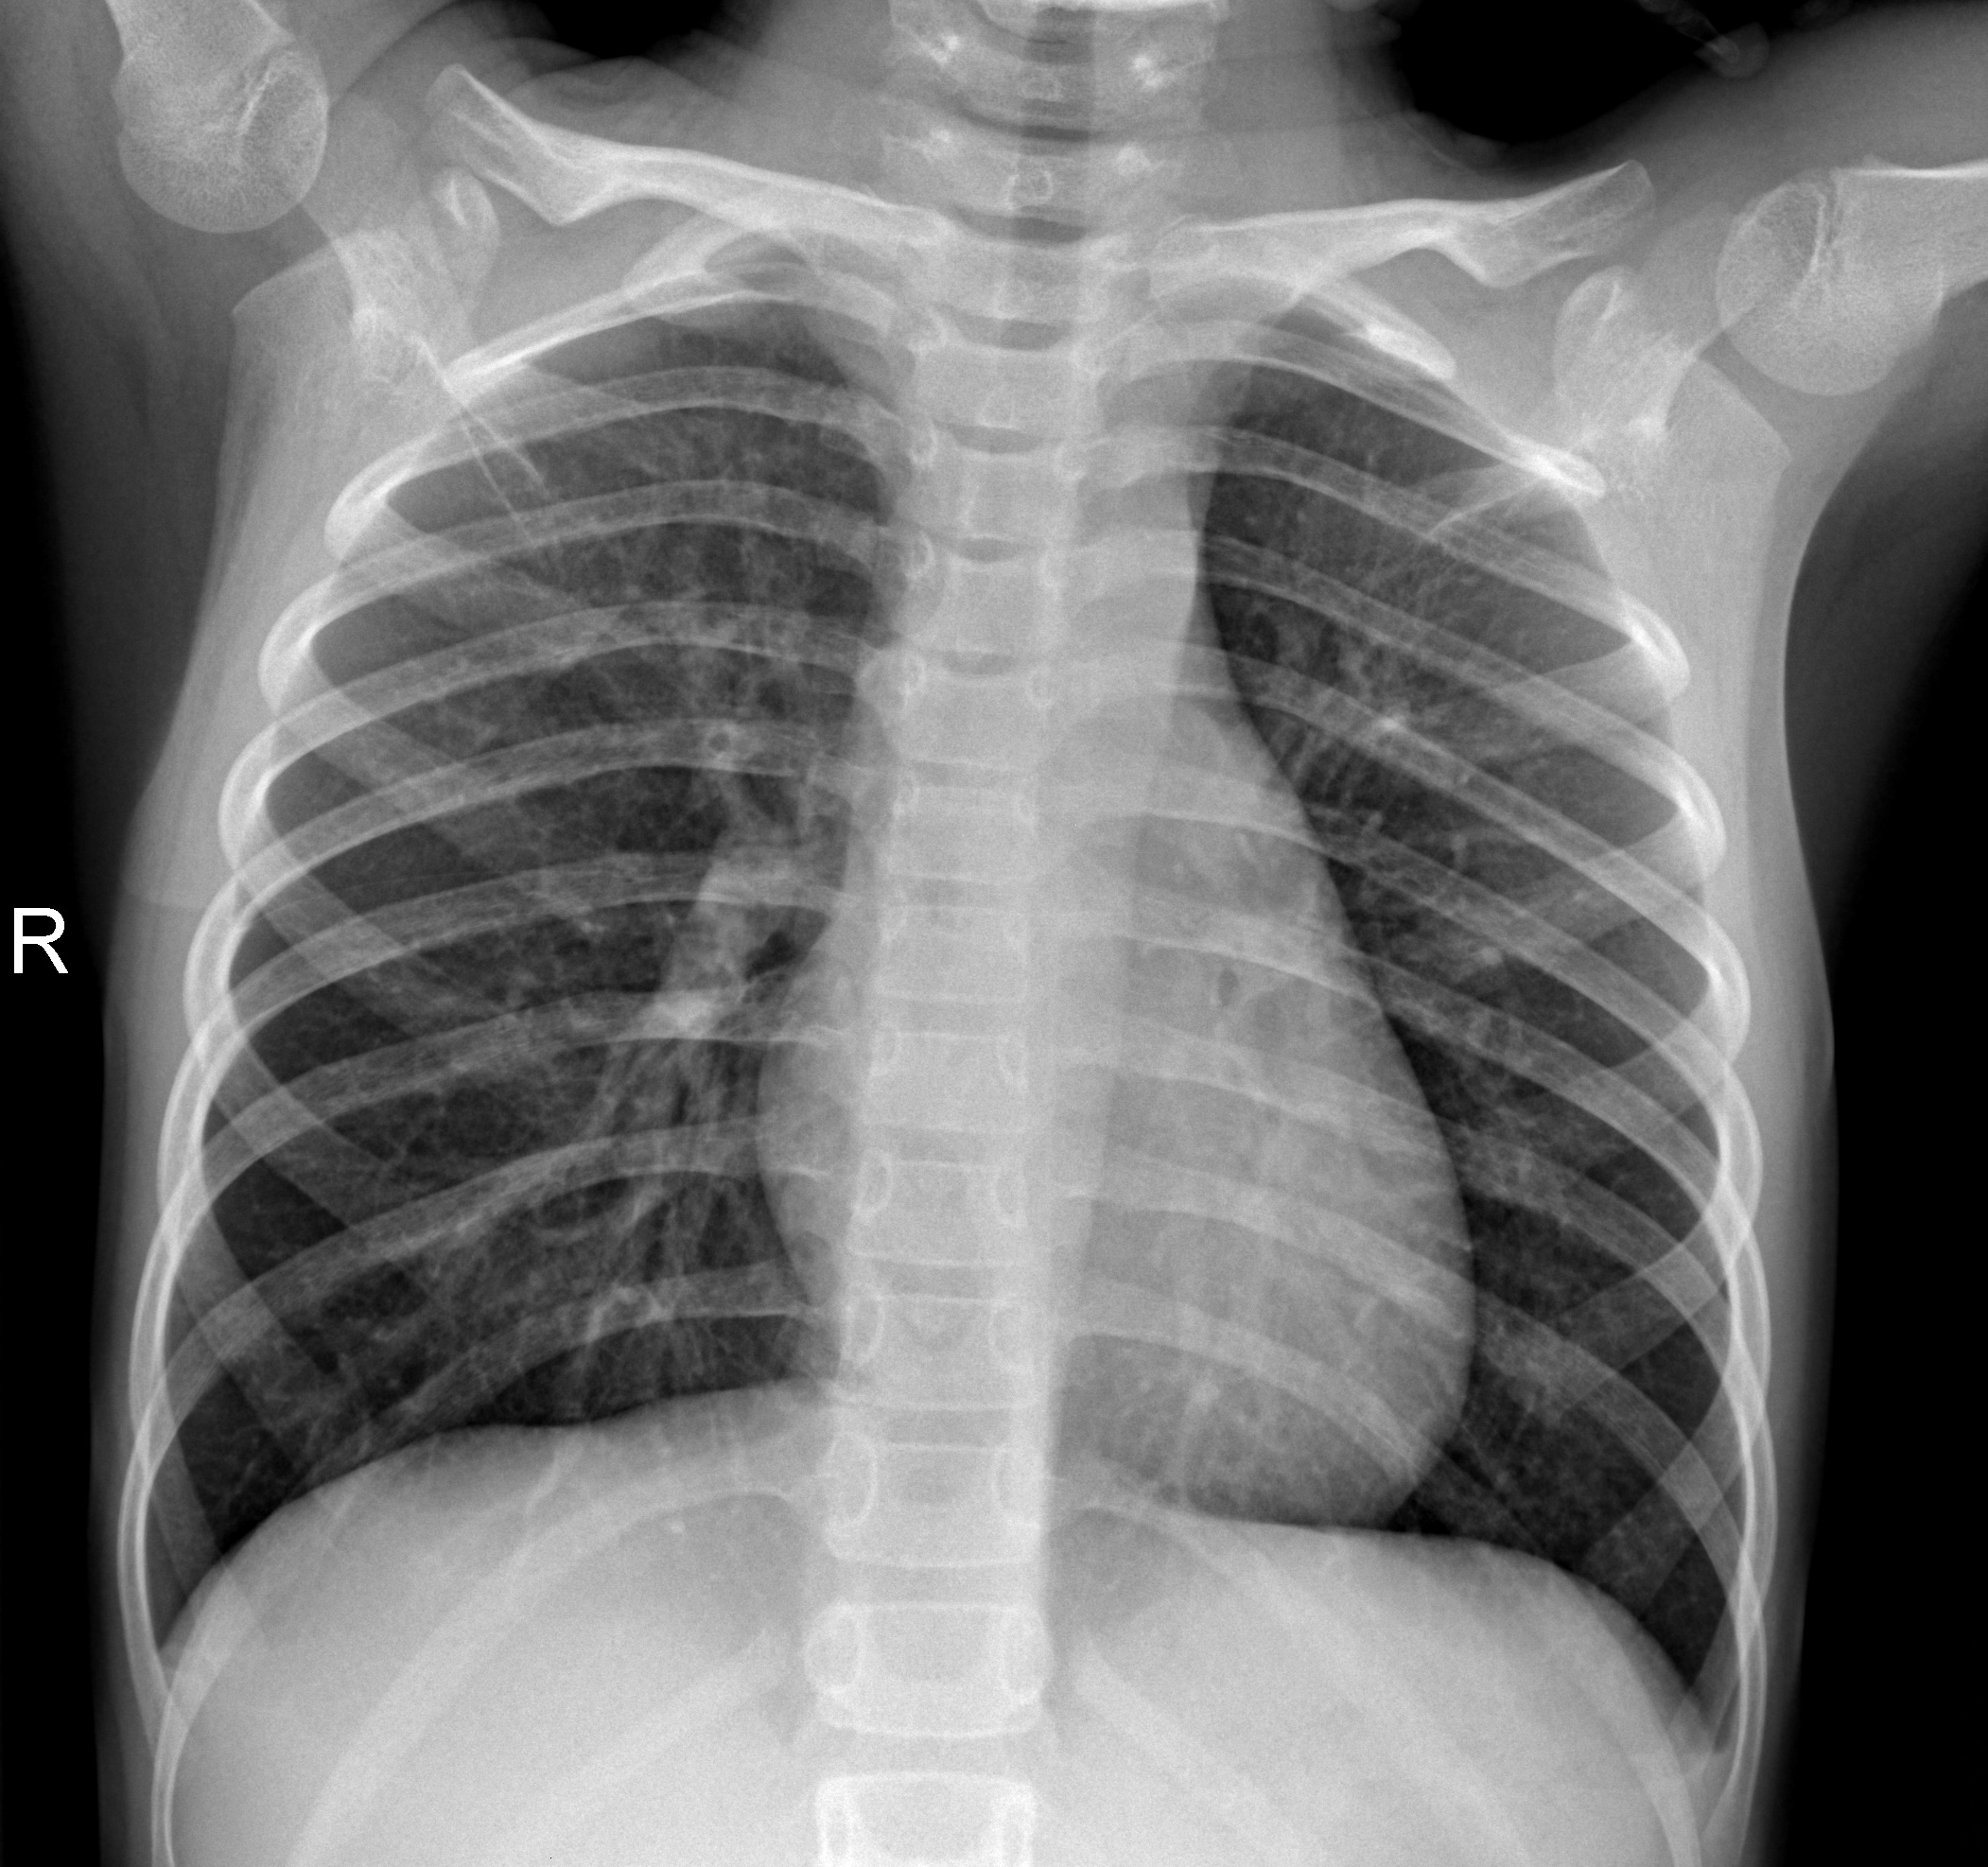

In [3]:
Image.open('./Data/chest_xray/train/normal/IM-0147-0001.jpeg').convert('RGB')

We can clearly see a full x-ray image of the upper torso, and the spine, heart, ribs, and shoulder are all easily visible. Of course, what we are really interested in are the lungs--you can faintly see their outline and some bronchi behind the ribs. Our network will need to pinpoint the lungs (and how healthy they are) specifically so we can give our patients a proper diagnosis.

You may have noticed that the x-ray seems quite large. In fact, the bulk of our images are well over 1000x1000 pixels in size! This size is definitely overkill for our classification task (not to mention the strain it puts on our poor GPU), so we can definitely afford to cut down the dimensions substantially. Thankfully, Pillow's **thumbnail** lets us easily reduce the image size (I'll use a factor of 1/8 per side), and includes a nice **Antialias** processing to help keep the image quality in the reduced dimensions.

Now let's take a look at a sick patient's x-ray

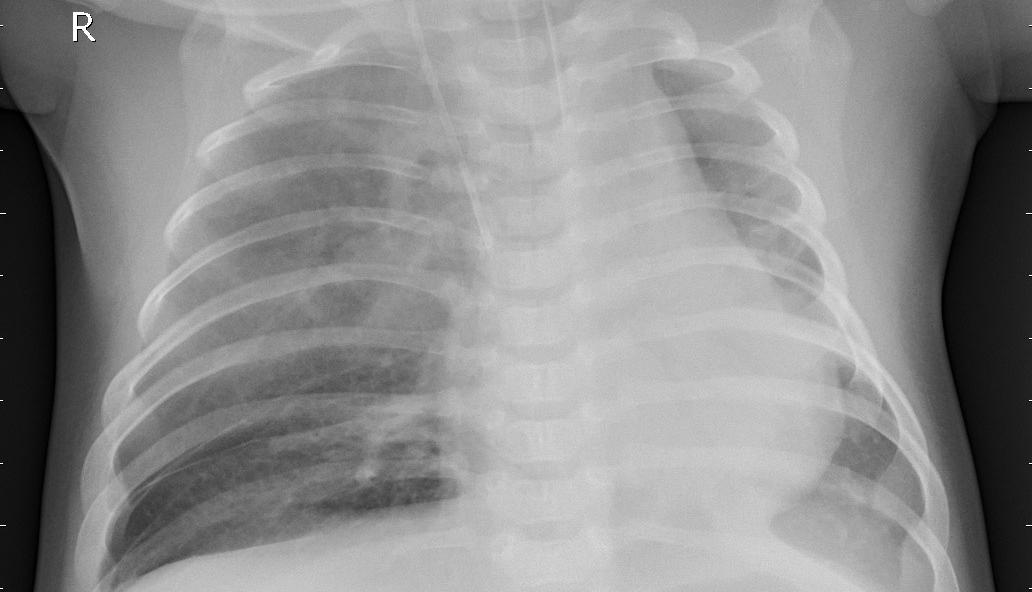

In [4]:
Image.open('./Data/chest_xray/train/pneumonia/person4_bacteria_14.jpeg').convert('RGB')

This patient looks quite a bit worse than the last. You can easily see the cloudy, inflamed lungs (careful though--the white lump on the right side is the heart--hopefully our network will be able to tell the difference!).

Looking at this image, we see there's a bit of a problem with our data. *The aspect ratios of the two previous images are totally different!* In fact, our entire dataset is a mishmash of various dimensions and sizes. While it's (hopefully) easy for a person to see that the two images above are of the same object (namely, the chest), our network may have some problems depending on how we deal with these discrepancies.

One option to deal with the matter would be to force all images into the same dimensions (say, a 216x216 square). While the uniformity would be easy to feed into our network, the result of this strategy would be that each image would be stretched and distorted in an unpredictable manner. Naturally, this would make it very difficult for the machine to be able to learn any helpful features from the data, and our accuracy would take a nosedive. (Even for the human eye, it can be a problem. Try it yourself: take your picture and stretch it horizontally or vertically--your face becomes practically unrecognizeable)

Rather than take the prior approach, I will instead seek to keep the images in their original aspect ratios (after size reduction). Then, I will utilize a **Fully Convolutional Network** (FCN) to handle the images. FCNs are similar to the standard Convolutional Network with one exception: *there are no fully connected layers!* Instead, FCNs stack convolutional blocks continually from input to output until the desired dimensions are achieved. This allows FCNs to handle input data of different dimensions, as the number of neuron connections (normally constant due to the fully connected layer constraints) can vary based on input size. With this architecture in mind, let's continue to process our images.

## Image Preprocessing and Data Generation

Right now, our images are still in their original forms, all stored as .jpeg files in the repository folder. We would like to implement some of the changes we discussed earlier and store them in a data format that we can feed into our FCN. We could simply process and store the whole dataset in one chunk, putting all the images in a single tensor or numpy array and then cutting up batches as need be. However, the size of these images is pretty massive as it is, and would needlessly tax our system to produce. Furthermore, setting up the batches, shuffling, and splitting procedures in this way is a bit of an ugly way to proceed, and goes against the high-level structure of Keras.

As such, I will employ a generator to take care of the image processing and batch storing all in one go. We can then pass this along to our Keras model, which will be able to use the generator to acquire the necessary data for each run. First, start with some preliminary parameters and paths:

In [5]:
# Determine training parameters
EPOCHS = 30
BATCHSIZE = 32
VALSPLIT = 0.9

path_ntr = './Data/chest_xray/train/normal/'
path_ptr = './Data/chest_xray/train/pneumonia/'

path_ntst = './Data/chest_xray/test/normal/'
path_ptst = './Data/chest_xray/test/pneumonia/'

To keep track of the images, I'm going to store the filenames and labels (0 for healthy patients, 1 for those with pneumonia) in 2 dictionaries. Note how I'm also employing my chosen validation split here, so we can already set aside those images and keep them out of the training loop.

In [6]:
norm_list = listdir(path_ntr)
pneu_list = listdir(path_ptr)
                    
ntrain_n = int(len(norm_list) * VALSPLIT)
ntrain_p = int(len(pneu_list) * VALSPLIT)

filenames = {'train': [], 'val': []}
labels = {}

# Loop through the normal xrays and store a label of '0'
ptr = 0
for file in norm_list:
    if ptr < ntrain_n:
        filenames['train'].append(file)
    else:
        filenames['val'].append(file)
    labels[file] = 0
    ptr += 1

# Now loop through the pneumonia xrays and give a label of '1'
ptr = 0
for file in pneu_list:
    if ptr < ntrain_p:
        filenames['train'].append(file)
    else:
        filenames['val'].append(file)
    labels[file] = 1
    ptr += 1

I also want to make a final dictionary for our test images. I'm keeping them separate as they won't be needed during the training runs.

In [7]:
norm_list_t = listdir(path_ntst)
pneu_list_t = listdir(path_ptst)
                    
ntest_n = len(norm_list_t)
ntest_p = len(pneu_list_t)

test_names = {'test': []}
test_labels = {}

for file in norm_list_t:
    test_names['test'].append(file)
    test_labels[file] = 0

for file in pneu_list_t:
    test_names['test'].append(file)
    test_labels[file] = 1

Next I set up the data generator as a keras sequence. This will handle training, testing, and validation batches, and will shuffle the images on each epoch to avoid unnecessary bias.

The image batch processing will be conducted as follows: First images will be opened with 3 color channels and then resized by (1/8, 1/8). The values will be stored in a numpy array and each rescaled to be between 0 and 1 for gradient stability. Finally, we will 0-pad the images until they are the same size as the largest image for that particular batch (this allows our gradients to have the same dimensions for each particular batch.

In [8]:
class Generator(Sequence):
    def __init__(self, IDs, labels, path_norm, path_pneu, batch_size=32, n_channels = 3, shuffle=True):
        self.IDs = IDs
        self.labels = labels
        self.path_norm = path_norm
        self.path_pneu = path_pneu
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.shuffle_batches()
    
    def __len__(self):
        '''
        For Keras data generator processing, return the number of batches per epoch
        '''
        return int(len(self.IDs) // self.batch_size)
    
    def __getitem__(self, idx):
        '''
        For Keras generator processing, this returns the current batch to the model with
        the appropriate labels.
        '''
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_IDs = [self.IDs[i] for i in indices]
        X, y = self.make_batch(batch_IDs, self.n_channels)
        
        return X, y
    
    def shuffle_batches(self):
        '''
        After each epoch, we will shuffle the images so we get different batches each time
        '''
        self.indices = np.arange(len(self.IDs))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def make_batch(self, batch_IDs, n_channels):
        '''
        This handles our processing and batch production. Returns a numpy array of
        size [batch_size, im_size, im_size, n_channels]
        
        batch_IDs (list): list of image filenames for the data
        n_channels (int): number of channels in each image
        '''
        paths = [self.path_norm, self.path_pneu]

        y = np.empty((self.batch_size), dtype=int)
        
        Xtemp = {}
        dims = 0
        
        # Open each image, resize to a thumbnail, and rescale to [0, 1]
        for i, ID in enumerate(batch_IDs):
            y_i = self.labels[ID]
            
            im = Image.open(paths[y_i] + ID).convert('RGB')
            im.thumbnail((im.width // 8, im.height // 8), Image.ANTIALIAS) # Antialias preserves jpeg quality
            if max(im.width, im.height) > dims:
                dims = max(im.width, im.height)
            
            im = np.asarray(im, dtype=np.float32)
            im /= 255.0
            Xtemp[i] = im
            y[i] = y_i
        
        # Now we find out the biggest image for our batch and pad the remaining ones to match
        X = np.empty((self.batch_size, dims, dims, n_channels), dtype=np.float32)
        for i in Xtemp:
            x_i = Xtemp[i]
            pad = ((0,dims-x_i.shape[0]), (0, dims-x_i.shape[1]), (0, 0))
            x_i = np.pad(x_i, pad_width=pad, mode='constant', constant_values=0)
            X[i, :, :, :] = x_i
        
        return X, tf.keras.utils.to_categorical(y, num_classes=2) # We'll return our labels as one-hot encoded variables

## Network Architecture

Now it's time to design and implement our FCN. FCN designs still follow the basics of creating a good CNN classifier; piece together several convolutional blocks, increasing the number
of features the network detects as you go. In each block, pool the results to downsize, apply your activation (somewhat optional, but I'm just using leaky ReLU to avoid neuron death), then normalize and push to the next block.

Input height and width dimensions are set to **None** to account for different sizes in each batch. The convolution kernels will start as 5x5 to learn larger features within the image, then slowly decrease to learn fine grain differences. The last two blocks use a 1x1 kernel--essentially, we are performing the same work as a fully connected layer but with the convolutional operation. Max Pooling is used in the initial layers to pick out the most imortant components of each convolutional output, while in the final block, we have a Global Average Pool to compress the final output into a single class prediction for each image. 

In [9]:
def make_FCN():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), input_shape=[None, None, 3]))
    model.add(layers.MaxPooling2D())
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, (3, 3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, (3, 3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(512, (1, 1)))
    model.add(layers.MaxPooling2D())
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(2, (1, 1)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Activation('softmax'))

    return model

## Weighing and Performance Metrics

Before we fit our FCN, we should note that there are roughly 3 times the number of sick patient x-rays as there are healthy x-rays

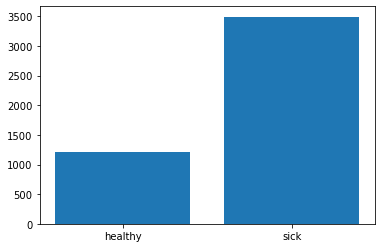

In [10]:
fig = plt.figure()
patients = ['healthy', 'sick']
numbers = [ntrain_n, ntrain_p]
plt.bar(patients, numbers)
plt.show()

This class imbalance isn't too egregious, but we should account for it regardless. I'm a bit loathe to cut the sick samples down (particularly since we only have <10,000 training samples) and trying to artificially generate new healthy samples introduces too many extra factors for such a small imbalance. Instead, I'm going to weigh the classes so that the FCN penalizes different class losses in proportion to their numbers in the dataset.

In [11]:
class_weight = {
    0: round((ntrain_n+ntrain_p)/(2*ntrain_n), 2),
    1: round((ntrain_n+ntrain_p)/(2*ntrain_p), 2)
}

Next we want to think about our performance metrics. Accuracy on its own might seem like a great way to determine how well our network is doing, but it doesn't tell the full story given our objective. In particular, since we are attempting to diagnose patients with a disease, we may like to know what proportion of positive (or negative) cases of pneumonia are correctly discovered. If, for example, we had a batch of 100 cases involving 98 healthy patients and 2 sick cases, by guessing that all are healthy, our network could achieve 98% accuracy *while completely missing both pneumonia patients.* 

To that end, medical research often uses Sensitivity and Specificity to evaluate a diagnosis. Sensitivity (true positives / true positives + false negatives) measures the proportion of sick patients that are correctly flagged by the network. Specificity (true negatives / true negatives + false positives) measures the proportion of healthy patients that are correctly designated. Thus, for instance, if we see our network displaying a low sensitivity, we can determine that the network may be putting out too many false negatives and a 'healthy' diagnosis wouldn't hold much water. Since Keras doesn't include Sensitivity and Specificity in its metrics library, I can code them from scratch and feed them into the model.

In [12]:
def sensitivity(y_true, y_pred):
    y_true = tf.math.argmax(y_true, axis=1)
    y_pred = tf.math.argmax(y_pred, axis=1)
    yp_neg = 1 - y_pred # 1 if predicted data is negative
    tp = K.sum(tf.math.multiply(y_true,y_pred))
    fn = K.sum(tf.math.multiply(yp_neg,y_true))
    sensitivity = tp / (tp + fn)
    return sensitivity

def specificity(y_true, y_pred):
    y_true = tf.math.argmax(y_true, axis=1)
    y_pred = tf.math.argmax(y_pred, axis=1)
    y_neg = 1 - y_true # 1 if true data is negative
    yp_neg = 1 - y_pred # 1 if predicted data is negative
    fp = K.sum(tf.math.multiply(y_neg,y_pred))
    tn = K.sum(tf.math.multiply(y_neg,yp_neg))
    specificity = tn / (tn + fp)
    return specificity

## Compiling Model and Training

From here on out, all there is to do is train the model. Using Adam to update the weights, and with the appropriate loss and metrics selected, we can generate our batches and begin our learning.

In [13]:
FCN = make_FCN()
FCN.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy', sensitivity, specificity],
            run_eagerly=True)

In [14]:
training_generator = Generator(filenames['train'], labels, path_ntr, path_ptr)
val_generator = Generator(filenames['val'], labels, path_ntr, path_ptr)
test_generator = Generator(test_names['test'], test_labels, path_ntst, path_ptst)

In [15]:
history = FCN.fit(x=training_generator,
                  epochs=EPOCHS,
                  verbose=2,
                  validation_data=val_generator,
                 class_weight=class_weight)

Epoch 1/30
147/147 - 123s - loss: 0.3695 - categorical_accuracy: 0.8259 - sensitivity: 0.7951 - specificity: 0.9324 - val_loss: 0.6700 - val_categorical_accuracy: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0137
Epoch 2/30
147/147 - 67s - loss: 0.2996 - categorical_accuracy: 0.8650 - sensitivity: 0.8348 - specificity: 0.9684 - val_loss: 0.9986 - val_categorical_accuracy: 0.2539 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/30
147/147 - 68s - loss: 0.2743 - categorical_accuracy: 0.8848 - sensitivity: 0.8592 - specificity: 0.9752 - val_loss: 0.9197 - val_categorical_accuracy: 0.2539 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/30
147/147 - 68s - loss: 0.2514 - categorical_accuracy: 0.8980 - sensitivity: 0.8751 - specificity: 0.9783 - val_loss: 0.4610 - val_categorical_accuracy: 0.8496 - val_sensitivity: 0.8720 - val_specificity: 0.7827
Epoch 5/30
147/147 - 68s - loss: 0.2393 - categorical_accuracy: 0.9045 - sensitivity: 0.8835 - specificity:

As you can see, we achieve a very nice accuracy, sensitivity, and specificity very quickly. I cut off the training after 30 epochs, but we could certainly push the performance even higher with longer training. The validation performance also is very close to the training runs, which is a good sign that we are not overfitting our data. Visually, we can look at the performance below.

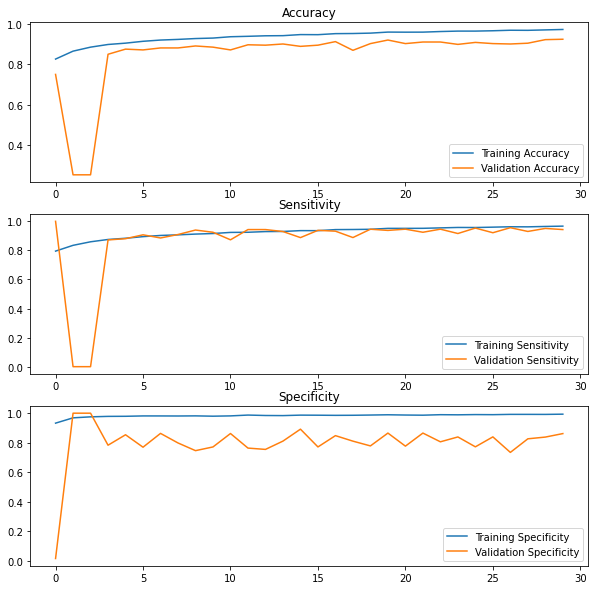

In [16]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

sens = history.history['sensitivity']
val_sens = history.history['val_sensitivity']

spec = history.history['specificity']
val_spec = history.history['val_specificity']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
#plt.ylim([0.65, 1.1])

plt.subplot(3, 1, 2)
plt.plot(epochs_range, sens, label='Training Sensitivity')
plt.plot(epochs_range, val_sens, label='Validation Sensitivity')
plt.legend(loc='lower right')
plt.title('Sensitivity')
#plt.ylim([0.6, 1.1])

plt.subplot(3, 1, 3)
plt.plot(epochs_range, spec, label='Training Specificity')
plt.plot(epochs_range, val_spec, label='Validation Specificity')
plt.legend(loc='lower right')
plt.title('Specificity')
#plt.ylim([0.4, 1.1])
plt.show()

After a bit of spurious initial epochs, we see the FCN very quickly achieve a nice stable level of performance.

Finally, let's see how we perform on the test data.

In [17]:
results = FCN.evaluate(test_generator)

19/19 [==============================] - 7s 370ms/step - loss: 0.2891 - categorical_accuracy: 0.8931 - sensitivity: 0.9888 - specificity: 0.7398


For comparison, in the paper "*Diagnostic Accuracy of Chest x-Ray and Ultrasonography in Detection of Community Acquired Pneumonia; a Brief Report*" by Taghizadieh, Ala, Rahmani, and Nadi, medical diagnoses of Pneumonia using chest X-rays showed a sensitivity of 93.1% using traditional methods (compare to our FCN's 98.88% sensitivity!)

In conclusion, we can see how effectively an FCN can classify images of various sizes and how relatively straightforward its implementation is using the Tensorflow Keras Library.